In [4]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../SourceCode')
import bastien_utils
from shallowAE import ShallowAE
from sparseShallowAE import SparseShallowAE_KL, SparseShallowAE_L1, SparseShallowAE_KL_sum
from nonNegShallowAE import NonNegShallowAE_NonNegConstraint, NonNegShallowAE_Asymmetric_decay
import datetime
import morphoMaths
import keras
import pandas as pd
keras.__version__

'2.2.0'

In [5]:
FILE_PATH = "../"
path_to_kl_div_sum = "../ShallowAE/Sparse/KL_div_sum/"
data = bastien_utils.load_data(FILE_PATH, train=False, test=True, subsetTest=True)
x_test, y_test, x_small, y_small = data
print('x_small shape:', x_small.shape)
print('x_test shape:', x_test.shape)

x_small shape: (10, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


# 1. Non Negativity Constraint

Non Negativity Constraint, with 400 epochs and early stopping. Keras 2.2.0.

In [3]:
pd.read_csv("../ShallowAE/NonNegativity/NonNegConstraint/TestOutputs/18_08_02results")

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,5.994843,0.599484,0.861,100,0.017343,0.363561,0.383347,0.608772,0.017336,0.362844,0.382139,0.608218


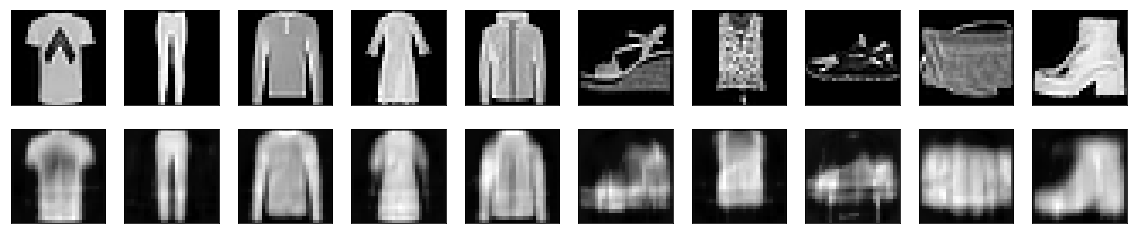

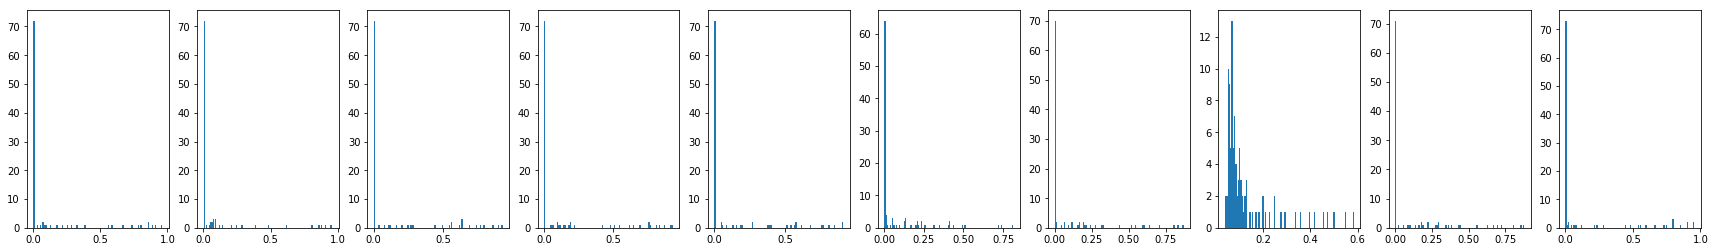

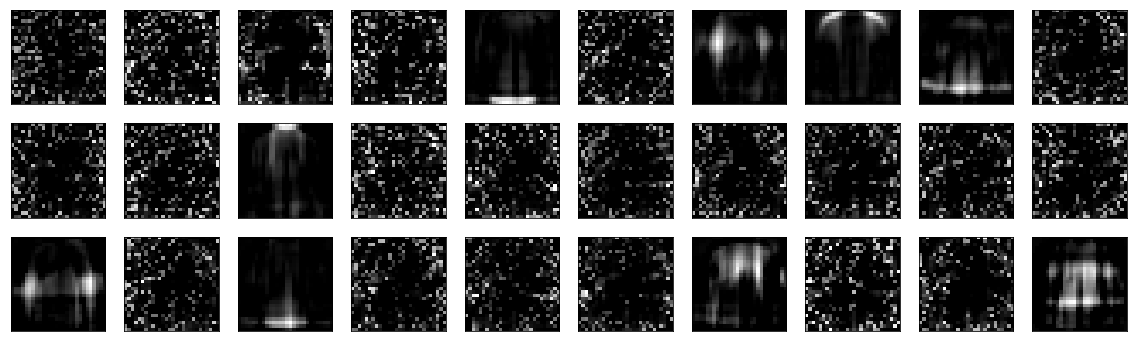

In [6]:
AE = NonNegShallowAE_NonNegConstraint.load('18_08_02_dim100_NonNegConstraint.h5')
AE.plot_reconstructions(x_small)
AE.plot_histograms_of_the_encoding(x_small)
AE.plot_atoms_decoder(nb_to_plot=30)

**Note that the Non Negativity constraint enforces parsity as many negative weights are set to zero.**

**The Non Negativity Constraint is advocated by the Deep Learning Book (explicit re projection rather than introduction of a KKT multiplier in the minimization of the cost function (equivalent to adding another cost function), but it may not be relevant in our case**

In [35]:
h_test = AE.encode(x_test)
h_small =AE.encode(x_small)

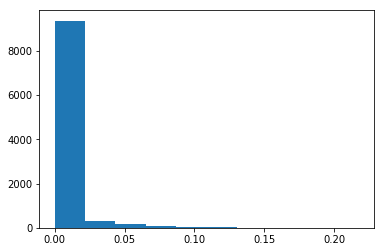

In [8]:
plt.hist(h_test[:,3])
plt.show()

In [29]:
new_h_small = np.array([h_small[i,:]*(h_small[i,:]>0.1) for i in range(10)])

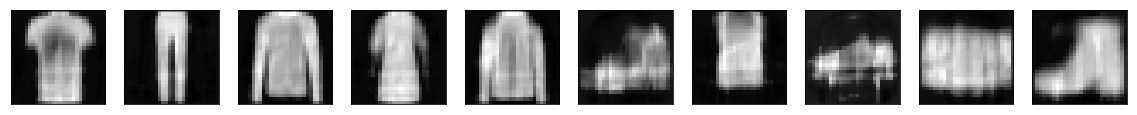

In [31]:
bastien_utils.plot_all_images(AE.decode(new_h_small))

In [32]:
AE.reconstruction_error(x_test)

0.017343405285477637

In [33]:
w,b = AE.decoder.get_weights()

In [39]:
w_new = np.array([w[i]*(np.mean(h_test[:,i])>0.1) for i in range(100)])

In [40]:
AE.decoder.set_weights([w_new,b])

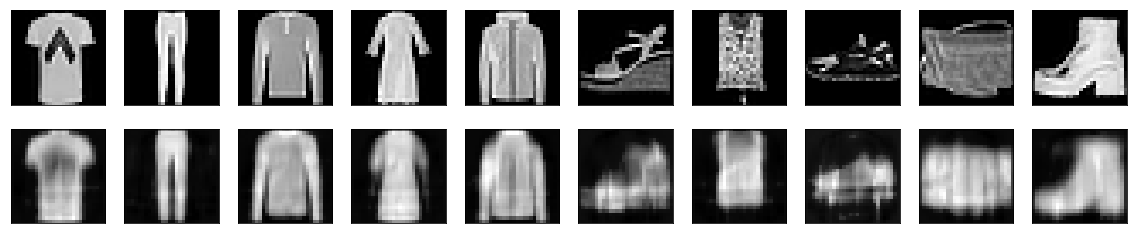

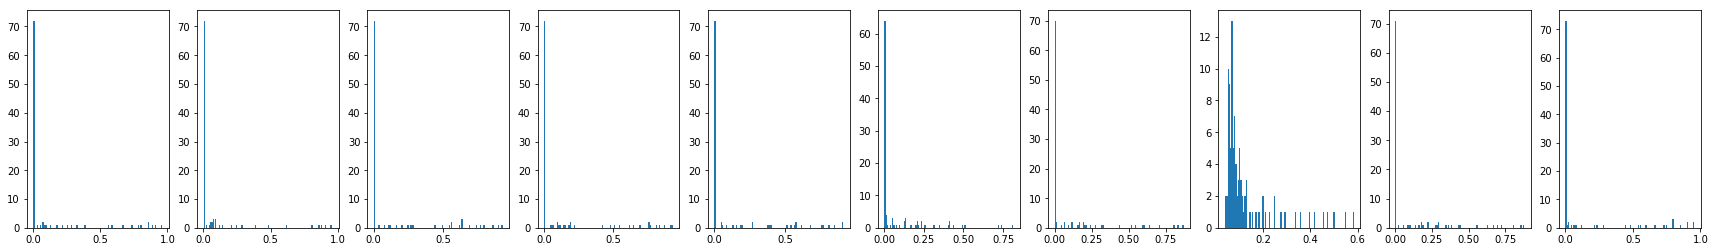

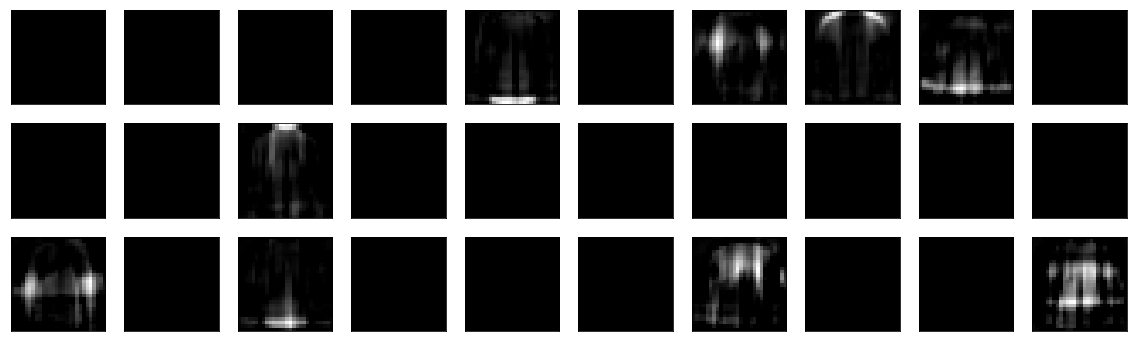

In [41]:
AE.plot_reconstructions(x_small)
AE.plot_histograms_of_the_encoding(x_small)
AE.plot_atoms_decoder(nb_to_plot=30)

In [42]:
AE.reconstruction_error(x_test)

0.017392933052778243

In [43]:
100*(0.017392933052778243-0.017343405285477637)/0.017343405285477637

0.2855711810072113

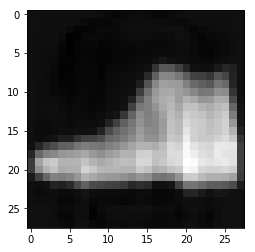

In [23]:
plt.imshow(AE.decode(new_h_test_0.reshape((1,100)))[0,:,:,0])
plt.show()

In [20]:
new_h_test_0.shape

(100,)

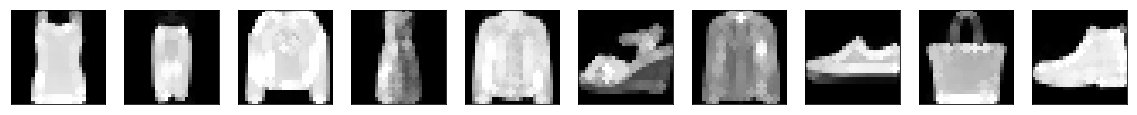

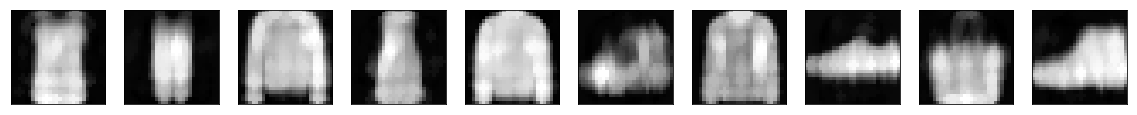

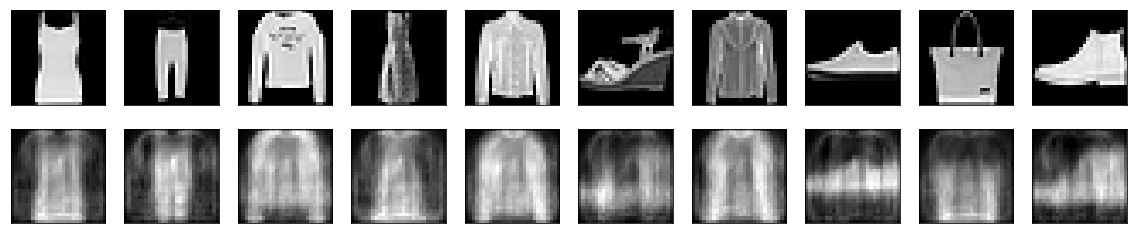

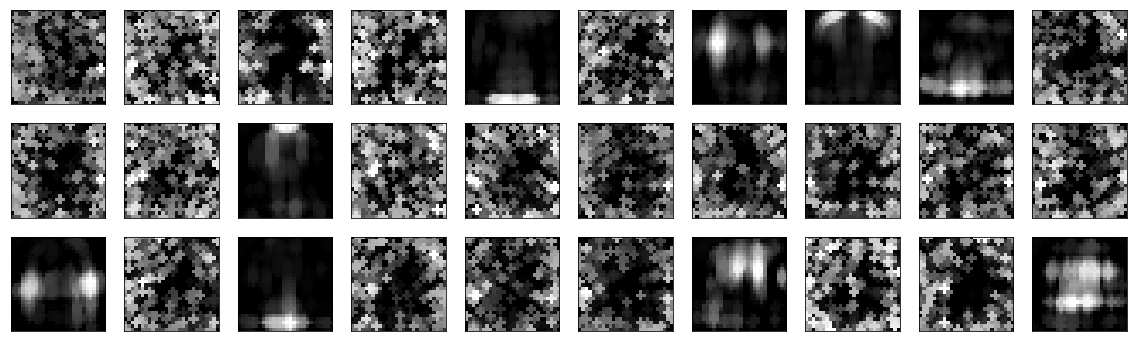

In [9]:
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=True, SE_scale=1)
AE_dil.plot_reconstructions(x_small)
AE_dil.plot_atoms_decoder(nb_to_plot=30)

**Slightly better max-approximation to dilatation than without the Non-Neg Constraint, as we can now differ the shapes of the various images.**

# 2. 500 epochs training

In [44]:
pd.read_csv("../ShallowAE/NonNegativity/NonNegConstraint/TestOutputs/18_08_13results")

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,1.668101,2.154435,0.834,100,0.015458,0.857519,0.888614,0.554005,0.015406,0.85635,0.886887,0.553727


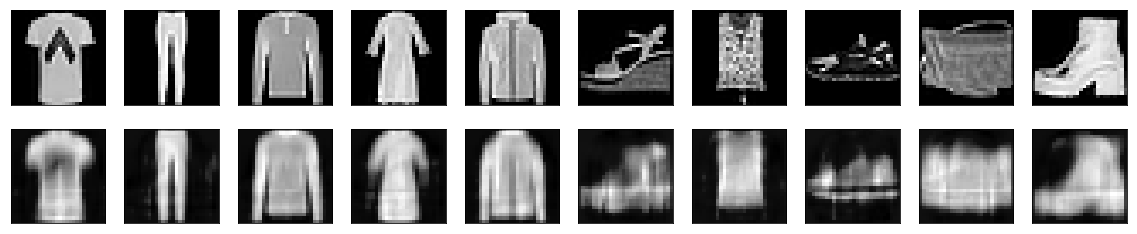

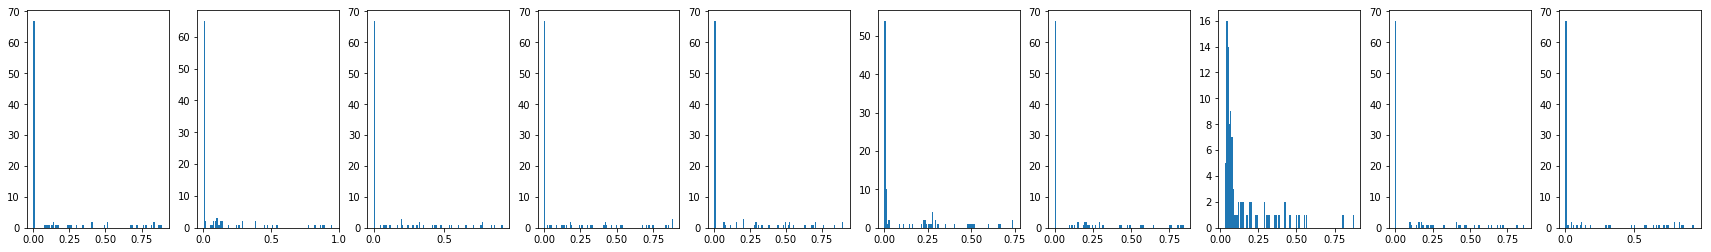

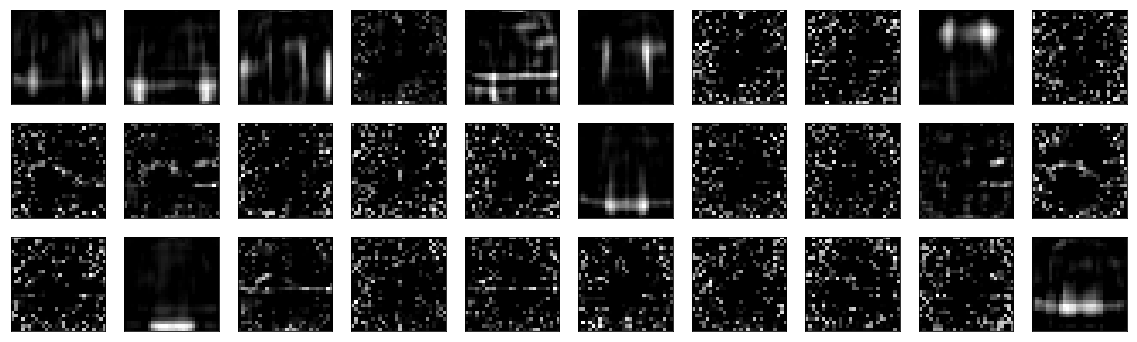

In [57]:
AE = NonNegShallowAE_NonNegConstraint.load('18_08_13_dim100_NonNegConstraint.h5')
AE.plot_reconstructions(x_small)
AE.plot_histograms_of_the_encoding(x_small)
AE.plot_atoms_decoder(nb_to_plot=30)

In [46]:
h_test=AE.encode(x_test)

In [56]:
np.sum(np.mean(h_test, axis=0)>0.1)

33

**Less unused dictionary images than with a shorter training**

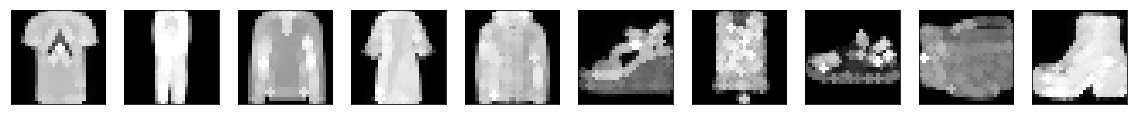

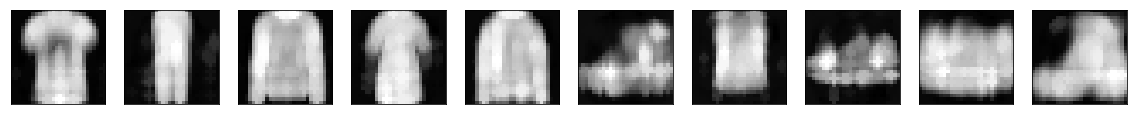

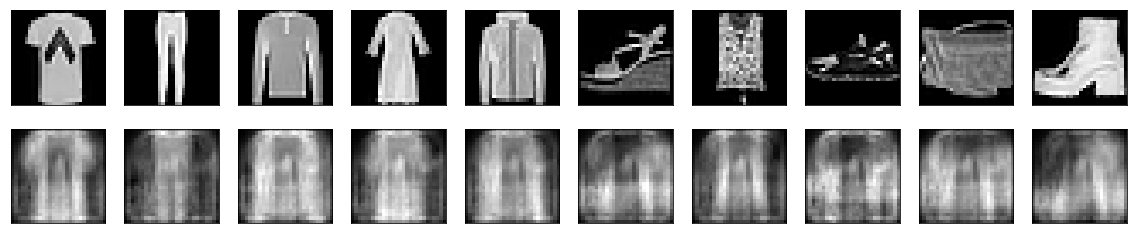

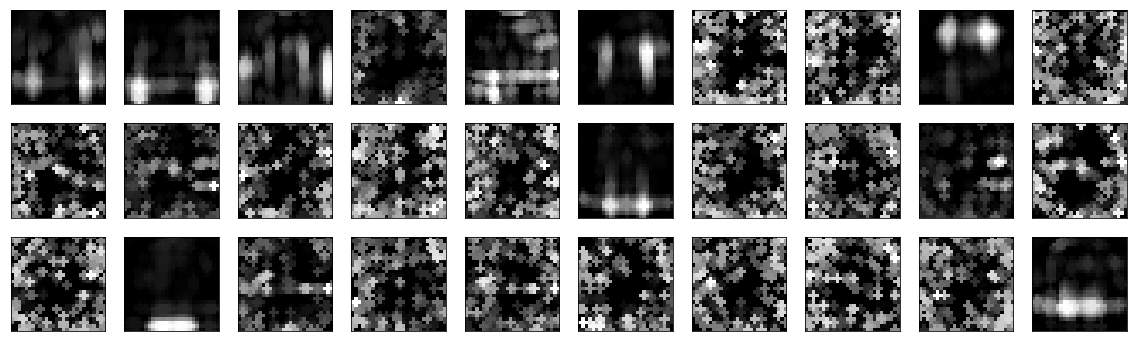

In [58]:
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=True, SE_scale=1)
AE_dil.plot_reconstructions(x_small)
AE_dil.plot_atoms_decoder(nb_to_plot=30)

# 3. With AMD (no original images)

In [63]:
pd.read_csv("../ShallowAE/SeveralChannels/WithAMD_NoOriginals/NonNegativity/NonNegConstraint/TestOutputs/18_08_07results")

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,21.544347,0.16681,0.856,100,0.01909,0.44555,0.429518,0.646899,0.019468,0.460931,0.438054,0.64459


In [61]:
x_small_input = morphoMaths.AMD_in_one_array(x_small[:,:,:,0], levels=5, add_original_images=False)

/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
/home/bastien/.conda/envs/StageENV/lib/python3.6/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for mult

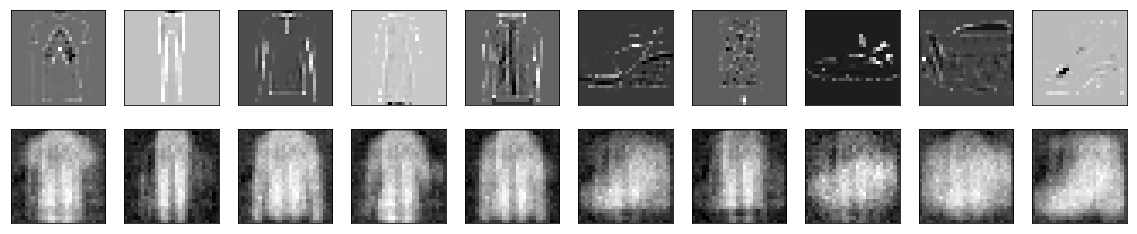

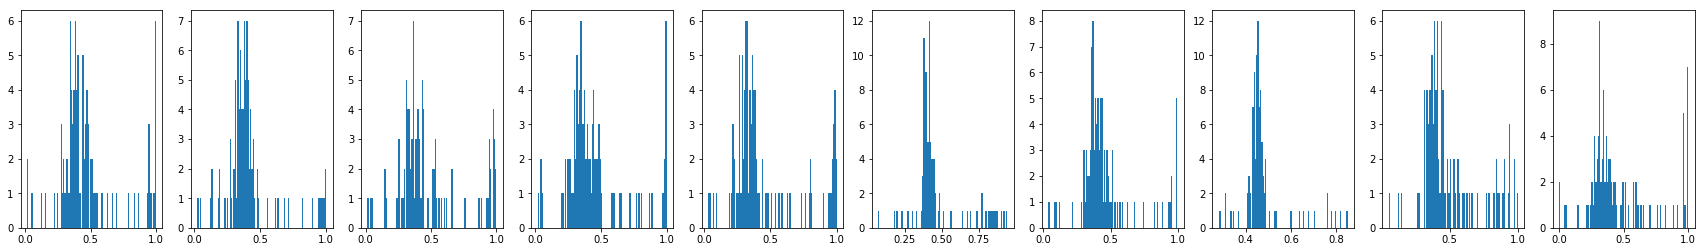

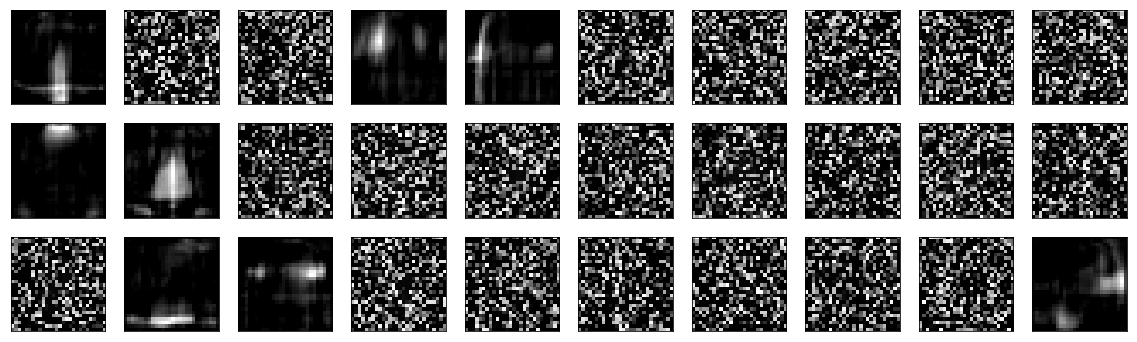

In [62]:
AE = NonNegShallowAE_NonNegConstraint.load('18_08_07_dim100_NonNegConstraint.h5', path_to_model_directory='../ShallowAE/SeveralChannels/WithAMD_NoOriginals/')
AE.plot_reconstructions(x_small_input)
AE.plot_histograms_of_the_encoding(x_small_input)
AE.plot_atoms_decoder(nb_to_plot=30)

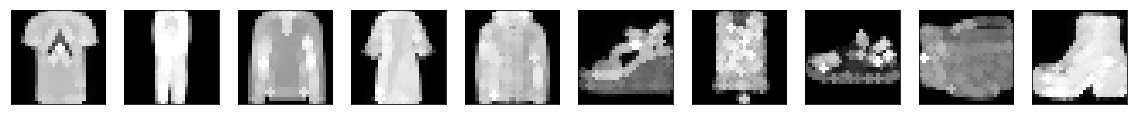

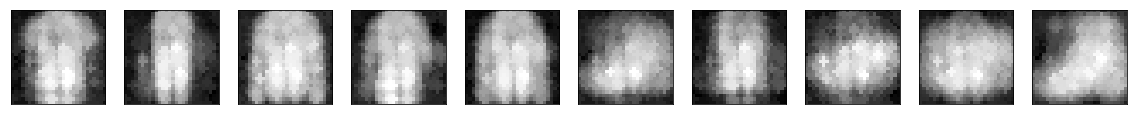

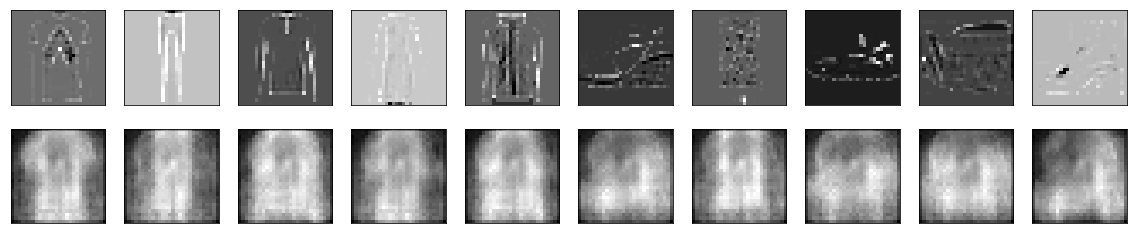

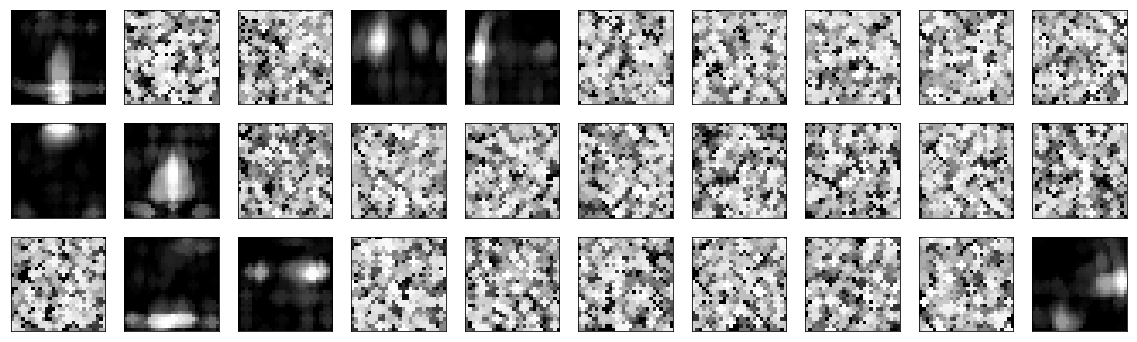

In [65]:
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small_input), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=True, SE_scale=1)
AE_dil.plot_reconstructions(x_small_input)
AE_dil.plot_atoms_decoder(nb_to_plot=30)